# LAB3 - Federico Piozzi


## Intro


In [1]:
from itertools import product, combinations, permutations
import numpy as np
import networkx as nx
from icecream import ic
import pandas as pd
import time
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

In [4]:
def create_problem(
    size: int,
    *,
    density: float = 1.0,
    negative_values: bool = False,
    noise_level: float = 0.0,
    seed: int = 42,
) -> np.ndarray:
    """Problem generator for Lab3"""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        if rng.random() < density:
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round()

In [5]:
problem = create_problem(10, density=0.15, noise_level=10, negative_values=True)

In [6]:
masked = np.ma.masked_array(problem, mask=np.isinf(problem))
G = nx.from_numpy_array(masked, create_using=nx.DiGraph)

In [7]:
for s, d in combinations(range(problem.shape[0]), 2):
    try:
        # path = nx.shortest_path(G, s, d, weight='weight')
        path = nx.bellman_ford_path(G, s, d, weight='weight')
        cost = cost = nx.path_weight(G, path, weight='weight')
    except nx.NetworkXNoPath:
        # Nodes are not connected
        path = None
        cost = np.inf
    except nx.NetworkXUnbounded:
        # Negative cycle detected
        path = None
        cost = -np.inf
    ic(s, d, path, cost)
None

ic| s: 0, d: 1, path: None, cost: -inf
ic| s: 0, d: 2, path: None, cost: -inf
ic| s: 0, d: 3, path: None, cost: -inf
ic| s: 0, d: 4, path: None, cost: -inf
ic| s: 0, d: 5, path: None, cost: -inf
ic| s: 0, d: 6, path: None, cost: -inf
ic| s: 0, d: 7, path: None, cost: -inf
ic| s: 0, d: 8, path: None, cost: -inf
ic| s: 0, d: 9, path: None, cost: -inf
ic| s: 1, d: 2, path: None, cost: -inf
ic| s: 1, d: 3, path: None, cost: -inf
ic| s: 1, d: 4, path: None, cost: -inf
ic| s: 1, d: 5, path: None, cost: -inf
ic| s: 1, d: 6, path: None, cost: -inf
ic| s: 1, d: 7, path: None, cost: -inf
ic| s: 1, d: 8, path: None, cost: -inf
ic| s: 1, d: 9, path: None, cost: -inf
ic| s: 2, d: 3, path: None, cost: -inf
ic| s: 2, d: 4, path: None, cost: -inf
ic| s: 2, d: 5, path: None, cost: -inf
ic| s: 2, d: 6, path: None, cost: -inf
ic| s: 2, d: 7, path: None, cost: -inf
ic| s: 2, d: 8, path: None, cost: -inf
ic| s: 2, d: 9, path: None, cost: -inf
ic| s: 3, d: 4, path: None, cost: -inf
ic| s: 3, d: 5, path: Non

In [20]:
rng = np.random.default_rng(42)

problem = rng.random((5, 5))
print(problem)
problem = problem * 2 - 1
print(problem)

[[0.77395605 0.43887844 0.85859792 0.69736803 0.09417735]
 [0.97562235 0.7611397  0.78606431 0.12811363 0.45038594]
 [0.37079802 0.92676499 0.64386512 0.82276161 0.4434142 ]
 [0.22723872 0.55458479 0.06381726 0.82763117 0.6316644 ]
 [0.75808774 0.35452597 0.97069802 0.89312112 0.7783835 ]]
[[ 0.5479121  -0.12224312  0.71719584  0.39473606 -0.8116453 ]
 [ 0.9512447   0.5222794   0.57212861 -0.74377273 -0.09922812]
 [-0.25840395  0.85352998  0.28773024  0.64552323 -0.1131716 ]
 [-0.54552256  0.10916957 -0.87236549  0.65526234  0.2633288 ]
 [ 0.51617548 -0.29094806  0.94139605  0.78624224  0.55676699]]


## Heuristic function

In [3]:
# heuristic function

# we need to modify create_problem function to return also the map used to compute the distances between nodes
def create_problem(
    size: int,
    *,
    density: float,
    negative_values: bool,
    noise_level: float,
    seed: int = 42,
) -> tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    map_coords = rng.random(size=(size, 2)) 
    problem = rng.random((size, size))
    
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    
    for a, b in product(range(size), repeat=2):
        if rng.random() < density:
            dist = np.linalg.norm(map_coords[a] - map_coords[b])
            problem[a, b] += dist
        else:
            problem[a, b] = np.inf
            
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round(), map_coords

def heuristic(u: int, v: int, coords: np.ndarray) -> float:
    return np.linalg.norm(coords[u] - coords[v]) * 1_000

## A* / Dijkstra

In [ ]:
# generic implementation of path search with optional heuristic
# A_star can be implemented by passing an heuristic function while Dijkstra without heuristic

def path_search(G, source, target, h=None):
    start_h = h(source,target) if h else 0
    open_set = [(start_h, 0, source, [source])]  # (f_score, count, node, path, g_score)

    visited = {}
    nodes_explored_count = 0

    while open_set:
        f, g, current, path = heapq.heappop(open_set)

        if current in visited and visited[current] <= g:
            continue

        visited[current] = g
        nodes_explored_count += 1

        if current == target:
            return g, path, nodes_explored_count
        
        for neighbor, data in G[current].items():
            weight = data['weight']
            new_g = g + weight
            
            if neighbor not in visited or new_g < visited[neighbor]:
                h_val = h(neighbor, target) if h else 0
                new_f = new_g + h_val
                heapq.heappush(open_set, (new_f, new_g, neighbor, path + [neighbor]))
    return np.inf, None, nodes_explored_count

## Search Algorithm

In [5]:
def format_time(seconds):
    if seconds < 1e-6: return f"{seconds * 1e9:.0f} ns"
    elif seconds < 1e-3: return f"{seconds * 1e6:.0f} µs"
    elif seconds < 1: return f"{seconds * 1e3:.2f} ms"
    else: return f"{seconds:.4f} s"

In [ ]:
sizes = [10, 20, 50, 100, 200, 500, 1000]
densities = [0.2, 0.5, 0.8, 1.0] 
noise_levels = [0.0, 0.1, 0.5, 0.8] 
negative_values = [False, True]

results = []
N_SAMPLES = 5 

print(f"Starting tests with {len(sizes) * len(densities) * len(noise_levels) * len(negative_values)} configurations...")

for size, density, noise, neg in product(sizes, densities, noise_levels, negative_values):
    
    matrix, coords = create_problem(
        size=size, 
        density=density, 
        negative_values=neg, 
        noise_level=noise, 
        seed=42
    )
    
    G = nx.from_numpy_array(matrix, create_using=nx.DiGraph)
    
    for _ in range(N_SAMPLES):
        source = random.randint(0, size - 1)
        target = random.randint(0, size - 1)
        while source == target: target = random.randint(0, size - 1)
        
        if not neg:
            # 1. A* (Informed)
            t0 = time.perf_counter()
            cost_a, _, nodes_a = path_search(G, source, target, h=lambda u, v: heuristic(u, v, coords))
            time_a = time.perf_counter() - t0
            results.append({'size': size, 'algo': 'A*', 'time': time_a, 'nodes': nodes_a, 'cost': cost_a})
            
            # 2. Dijkstra (Uninformed: h=0)
            t0 = time.perf_counter()
            cost_d, _, nodes_d = path_search(G, source, target, h=lambda u, v: 0)
            time_d = time.perf_counter() - t0
            results.append({'size': size, 'algo': 'Dijkstra', 'time': time_d, 'nodes': nodes_d, 'cost': cost_d})
        
        else:
            # 3. Bellman-Ford
            t0 = time.perf_counter()
            try:
                path_b = nx.bellman_ford_path(G, source, target, weight='weight')
                cost_b = nx.path_weight(G, path_b, weight='weight')
                # put nan as nodes explored since BF does not "explore nodes" in the same sense, it visits all edges V-
                nodes_b = np.nan 
            except:
                cost_b = np.inf
                nodes_b = np.nan
            time_b = time.perf_counter() - t0
            results.append({'size': size, 'algo': 'Bellman-Ford', 'time': time_b, 'nodes': nodes_b, 'cost': cost_b})

df = pd.DataFrame(results)

Starting tests with 224 configurations...


## Result Analysis

In [ ]:
# TEST RESULTS ANALYSIS

df['time_readable'] = df['time'].apply(format_time)

columns_to_show = ['size', 'algo', 'time', 'nodes', 'cost']

sample_view = df.groupby(['size', 'algo'])[columns_to_show].apply(
    lambda x: x.sample(min(len(x), 2), random_state=42)
)

print("\n--- RESULT EXAMPLES ---")
print(sample_view)

print("\n--- AVERAGES: TIME AND EXPLORED NODES ---")

summary = df.groupby(['size', 'algo'])[['time', 'nodes', 'cost']].mean()

summary['time_formatted'] = summary['time'].apply(format_time)

print(summary[['time_formatted', 'nodes', 'cost']])


--- RESULT EXAMPLES ---
                        size          algo      time  nodes    cost
size algo                                                          
10   A*           90      10            A*  0.000135   10.0  1938.0
                  0       10            A*  0.000084    2.0   703.0
     Bellman-Ford 100     10  Bellman-Ford  0.000021    NaN     inf
                  10      10  Bellman-Ford  0.000350    NaN  1038.0
     Dijkstra     91      10      Dijkstra  0.000029   10.0  1938.0
                  1       10      Dijkstra  0.000021    4.0   703.0
20   A*           330     20            A*  0.000147    3.0  1055.0
                  240     20            A*  0.000139    3.0   879.0
     Bellman-Ford 340     20  Bellman-Ford  0.000062    NaN     inf
                  250     20  Bellman-Ford  0.000129    NaN  1026.0
     Dijkstra     331     20      Dijkstra  0.000099   13.0  1055.0
                  241     20      Dijkstra  0.000110   13.0   879.0
50   A*           570  

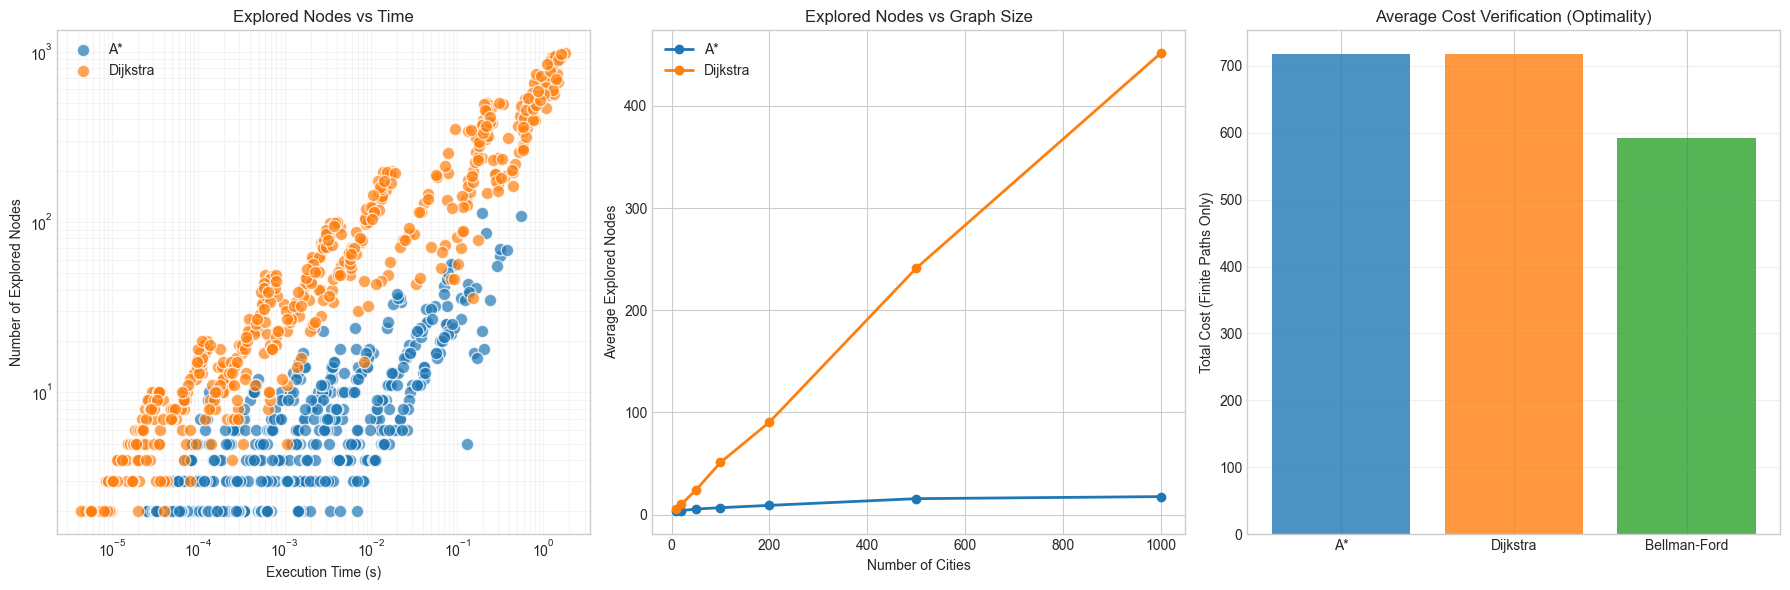


--- DIRECT COMPARISON ON SPECIFIC EXAMPLES ---
Comparison of the first valid sample found for each Size/Algorithm pair.

     time_readable                         nodes                         cost                      
algo            A* Bellman-Ford   Dijkstra    A* Bellman-Ford Dijkstra     A* Bellman-Ford Dijkstra
size                                                                                               
10           84 µs       350 µs      21 µs   2.0          NaN      4.0  703.0       1038.0    703.0
20          139 µs       129 µs     110 µs   3.0          NaN     13.0  879.0       1026.0    879.0
50          169 µs       610 µs     232 µs   2.0          NaN     11.0  466.0        546.0    466.0
100        2.28 ms      2.33 ms    3.89 ms   8.0          NaN     92.0  770.0        589.0    770.0
200        1.92 ms      9.05 ms   13.48 ms   4.0          NaN    138.0  674.0        463.0    674.0
500        1.41 ms     50.79 ms  179.80 ms   2.0          NaN    351.0  619.0 

In [21]:
df_clean = df.dropna(subset=['size', 'algo']).copy()
df_found = df_clean[np.isfinite(df_clean['cost'])].copy()

plt.figure(figsize=(18, 6))

colors = {'A*': '#1f77b4', 'Dijkstra': '#ff7f0e', 'Bellman-Ford': '#2ca02c'}

# --- PLOT 1: Explored Nodes vs Time ---
plt.subplot(1, 3, 1)
for algo in ['A*', 'Dijkstra']: 
    subset = df_clean[(df_clean['algo'] == algo) & (df_clean['time'] > 0) & (df_clean['nodes'] > 0)]
    if not subset.empty:
        plt.scatter(subset['time'], subset['nodes'], label=algo, alpha=0.7, s=80, color=colors[algo], edgecolors='w')

plt.title('Explored Nodes vs Time')
plt.xlabel('Execution Time (s)')
plt.ylabel('Number of Explored Nodes')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# --- PLOT 2: Explored Node vs Size ---
plt.subplot(1, 3, 2)

means = df_found[df_found['algo'].isin(['A*', 'Dijkstra'])].groupby(['size', 'algo'])['nodes'].mean().unstack()

for algo in ['A*', 'Dijkstra']:
    if algo in means.columns:
        plt.plot(means.index, means[algo], marker='o', label=algo, linewidth=2, color=colors[algo])

plt.title('Explored Nodes vs Graph Size')
plt.xlabel('Number of Cities')
plt.ylabel('Average Explored Nodes')
plt.legend()

# --- PLOT 3: Optimality ---
plt.subplot(1, 3, 3)
cost_means = df_found.groupby('algo')['cost'].mean()

algos_ordered = [a for a in ['A*', 'Dijkstra', 'Bellman-Ford'] if a in cost_means.index]

plt.bar(algos_ordered, [cost_means[a] for a in algos_ordered], 
        color=[colors[a] for a in algos_ordered], alpha=0.8)

plt.title('Average Cost Verification (Optimality)')
plt.ylabel('Total Cost (Finite Paths Only)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



print("\n--- DIRECT COMPARISON ON SPECIFIC EXAMPLES ---")
print("Comparison of the first valid sample found for each Size/Algorithm pair.\n")

examples = df_clean.groupby(['size', 'algo']).first().reset_index()

examples['time_readable'] = examples['time'].apply(format_time)

pivot_table = examples.pivot(index='size', columns='algo', values=['time_readable', 'nodes', 'cost'])

print(pivot_table.to_string())